# Download and inspect some model results from Ponte and Klein, 2015

https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/HU58SG

TODO:

- Function to read data into a "nicer" xarray format
- Movie of low freq SSH and tidal SSH
-  "        "  vorticity and tidal northward velocity 
- Time series reconsutrction of total SSH/velocity
- PSD of raw signal

In [1]:
## Download the data
#!curl https://dataverse.scholarsportal.info/api/access/datafile/170108 -o ../DATA/wp50-t1.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170118 ../DATA/wp50-t2.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170113 ../DATA/wp90-t1.nc
# !wget https://dataverse.scholarsportal.info/api/access/datafile/170112 ../DATA/wp90-t2.nc

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from cmocean import cm
from scipy.interpolate import interp1d
from scipy import signal
from matplotlib.animation import FuncAnimation, PillowWriter, writers, FFMpegWriter

In [3]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14

In [4]:
# ds = xr.open_mfdataset('../DATA/wp50-t*.nc', concat_dim='time_centered_bounds')
ds = xr.open_dataset('../DATA/wp90-t2.nc')

ds

<xarray.Dataset>
Dimensions:               (y_rho: 722, x_rho: 258, y_u: 722, x_u: 257, y_v: 721, x_v: 258, s_rho_slice0: 1, time_counter: 50, axis_nbounds: 2)
Coordinates:
    nav_lat_rho           (y_rho, x_rho) float32 ...
    nav_lat_u             (y_u, x_u) float32 ...
    nav_lat_v             (y_v, x_v) float32 ...
    nav_lon_rho           (y_rho, x_rho) float32 ...
    nav_lon_u             (y_u, x_u) float32 ...
    nav_lon_v             (y_v, x_v) float32 ...
  * s_rho_slice0          (s_rho_slice0) float32 -0.01
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 1950-01-01T12:00:00 ....
    time_instant          (time_counter) datetime64[ns] ...
Dimensions without coordinates: y_rho, x_rho, y_u, x_u, y_v, x_v, axis_nbounds
Data variables: (12/21)
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    u_xy_cos              (time_counter, s_rho_slice0, y_u, x_u) float32 ...
    u_xy_sin              (time_counter, s_rho_slice0, y_u, x_u) float32 ...
    v_xy_cos              (time_counter, s_rho_slice0, y_v, x_v) float32 ...
    v_xy_sin              (time_counter, s_rho_slice0, y_v, x_v) float32 ...
    ...                    ...
    T_xy_ins              (time_counter, s_rho_slice0, y_rho, x_rho) float32 ...
    ssh_ins               (time_counter, y_rho, x_rho) float32 ...
    time_instant_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    u_xy_ins              (time_counter, s_rho_slice0, y_u, x_u) float32 ...
    v_xy_ins              (time_counter, s_rho_slice0, y_v, x_v) float32 ...
    w_xy_ins              (time_counter, s_rho_slice0, y_rho, x_rho) float32 ...
Attributes:
    name:                       file_surf
    description:                Created by xios
    title:                      Created by xios
    Conventions:                CF-1.5
    production:                 An IPSL model
    timeStamp:                  2019-Sep-26 12:44:30 GMT
    history:                    Fri May 28 17:45:21 2021: ncks -A /data2/nico...
    NCO:                        4.7.2
    nco_openmp_thread_number:   1
    history_of_appended_files:  Fri May 28 17:45:21 2021: Appended file /data...

In [5]:
# Create nicer dimensions
def load_data(ncfile,datavar='ssh'):
    ds = xr.open_dataset(ncfile)
    dx = 4.0
    if len(ds['{}_lof'.format(datavar)].dims)==4:
        tdim, zdim, ydim, xdim = ds['{}_lof'.format(datavar)].dims
    else:
        tdim, ydim, xdim = ds['{}_lof'.format(datavar)].dims
    x = ds[xdim].values*dx
    y = ds[ydim].values*dx

    t0 = np.datetime64('1950-01-01 00:00:00')
    tdays = (ds.time_centered.values - t0).astype(float)*1e-9/86400.
    print(ncfile, tdays[0], tdays[-1])
    return xr.Dataset(
        {'{}_lof'.format(datavar):
            xr.DataArray(ds['{}_lof'.format(datavar)].squeeze(), coords={'x':x,'y':y, 'time':tdays}, dims=('time','y','x')),
         '{}_cos'.format(datavar):
            xr.DataArray(ds['{}_cos'.format(datavar)].squeeze(), coords={'x':x,'y':y, 'time':tdays}, dims=('time','y','x')),
         '{}_sin'.format(datavar):
            xr.DataArray(ds['{}_sin'.format(datavar)].squeeze(), coords={'x':x,'y':y, 'time':tdays}, dims=('time','y','x')),
        })


In [7]:
scenario = 'wp90'
ds_v = xr.concat([load_data(ff, datavar='v_xy') for ff in glob('../DATA/{}-t*.nc'.format(scenario))], dim='time')
ds_u = xr.concat([load_data(ff, datavar='u_xy') for ff in glob('../DATA/{}-t*.nc'.format(scenario))], dim='time')
ds_ssh = xr.concat([load_data(ff, datavar='ssh') for ff in glob('../DATA/{}-t*.nc'.format(scenario))], dim='time')

nt =  ds_ssh.time.shape[0]
dt=2
ds_ssh['time']= np.arange(0, nt*dt,dt)
ds_u['time']= np.arange(0, nt*dt,dt)
ds_v['time']= np.arange(0, nt*dt,dt)


ds_ssh

../DATA/wp90-t1.nc 1.0 99.0
../DATA/wp90-t2.nc 1.0 99.0
../DATA/wp90-t1.nc 1.0 99.0
../DATA/wp90-t2.nc 1.0 99.0
../DATA/wp90-t1.nc 1.0 99.0
../DATA/wp90-t2.nc 1.0 99.0


<xarray.Dataset>
Dimensions:  (x: 258, y: 722, time: 100)
Coordinates:
  * x        (x) float64 0.0 4.0 8.0 12.0 ... 1.02e+03 1.024e+03 1.028e+03
  * y        (y) float64 0.0 4.0 8.0 12.0 ... 2.876e+03 2.88e+03 2.884e+03
  * time     (time) int64 0 2 4 6 8 10 12 14 ... 184 186 188 190 192 194 196 198
Data variables:
    ssh_lof  (time, y, x) float32 0.7023 0.7023 0.7023 ... -0.7028 -0.7028
    ssh_cos  (time, y, x) float32 1.746e-06 1.771e-06 ... -0.000921 -0.0009255
    ssh_sin  (time, y, x) float32 9.635e-06 9.576e-06 ... -0.0001985 -0.0001933

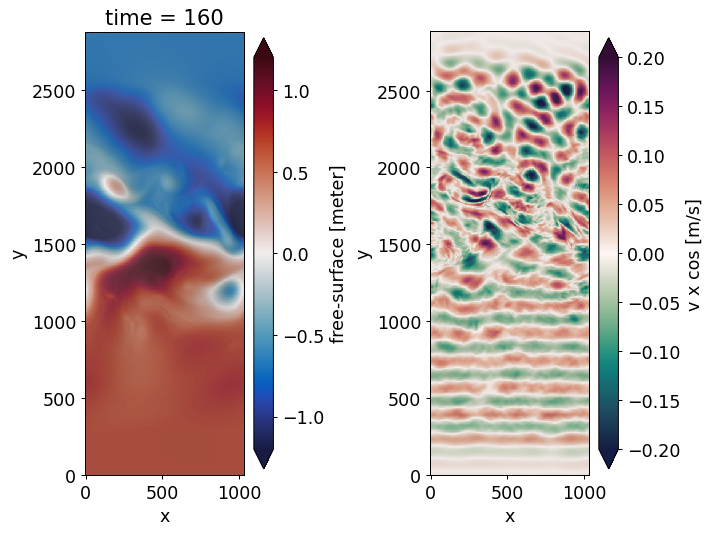

In [8]:
def initplot(tstep=0):
    fig = plt.figure(figsize=(8,10), dpi=90)
    ax1=plt.subplot(121)
    c1=ds_ssh['ssh_lof'][tstep,...].plot(vmin=-1.2, vmax=1.2, cmap=cm.balance, cbar_kwargs={'shrink':0.5})
    c2=ds_v['v_xy_lof'][tstep,...].plot(cmap='gist_gray', alpha=0.25, add_colorbar=False)
    ax1.set_aspect('equal')

    ax2=plt.subplot(122)
    #amp = np.abs( ds_v['v_xy_cos'][tstep,...] +1j * ds_v['v_xy_sin'][tstep,...])
    #c3=amp.plot(vmin=0, vmax=0.2, cmap=cm.speed, cbar_kwargs={'shrink':0.5})
    c3=ds_v['v_xy_cos'][tstep,...].plot(vmin=-0.2, vmax=0.2, cmap=cm.curl, cbar_kwargs={'shrink':0.5})
    c4= ds_ssh['ssh_cos'][tstep,...].plot(cmap='gist_gray', alpha=0.1, add_colorbar=False)
    ax2.set_aspect('equal')
    ax2.set_title('')
    plt.tight_layout()
    return fig, ax1, ax2, c1, c2, c3, c4

fig, ax1, ax2, c1, c2, c3, c4 = initplot(tstep=80)


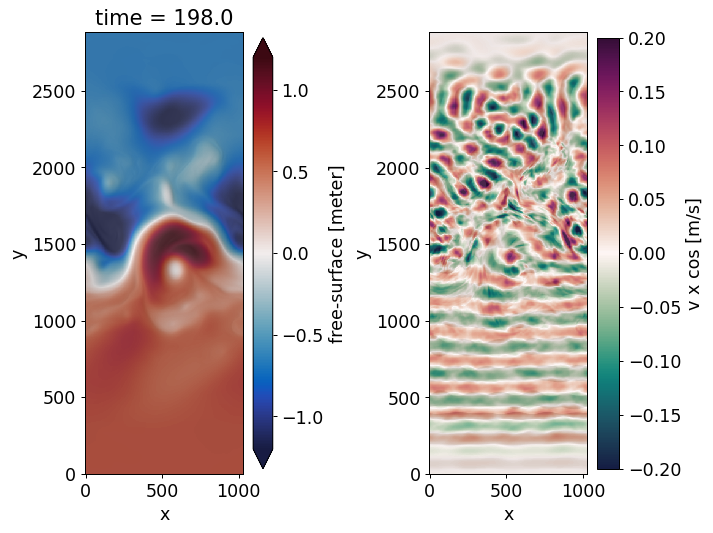

In [9]:
fig, ax1, ax2, c1, c2, c3, c4 = initplot(tstep=0)

def update(tstep):
        
    c1.set_array(ds_ssh['ssh_lof'][tstep,...].values.ravel())
    c2.set_array(ds_v['v_xy_lof'][tstep,...].values.ravel())
    #amp = np.abs( ds_v['v_xy_cos'][tstep,...] +1j * ds_v['v_xy_sin'][tstep,...])
    c3.set_array(ds_v['v_xy_cos'][tstep,...].values.ravel())
    c4.set_array(ds_ssh['ssh_cos'][tstep,...].values.ravel())

    ax1.set_title('time = {:3.1f}'.format(ds_ssh.time.values[tstep]))
    
    #return ax1, c1, c2, c3, c4

anim = FuncAnimation(fig, update, frames=range(0, nt),  blit=False)
FFwriter = FFMpegWriter(fps=6, bitrate=-1, extra_args=['-vcodec', 'libx264','-pix_fmt', 'yuv420p'])
# FFwriter = FFMpegWriter(fps=6)

anim.save('../FIGURES/{}.mp4'.format(scenario), writer = FFwriter)

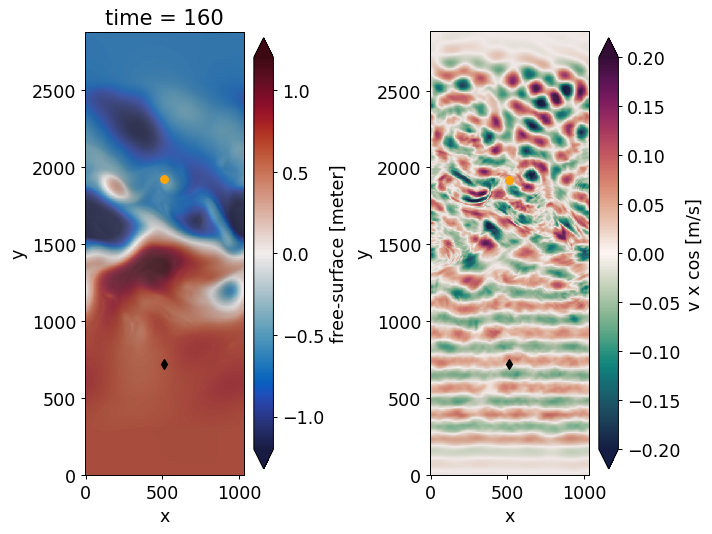

In [10]:
fig, ax1, ax2, c1, c2, c3, c4 = initplot(tstep=80)
ax1.plot(ds_ssh['x'][128], ds_ssh['y'][180],'kd')
ax1.plot(ds_ssh['x'][128], ds_ssh['y'][480],'orange',marker='o')

ax2.plot(ds_ssh['x'][128], ds_ssh['y'][180],'kd')
ax2.plot(ds_ssh['x'][128], ds_ssh['y'][480],'orange',marker='o')

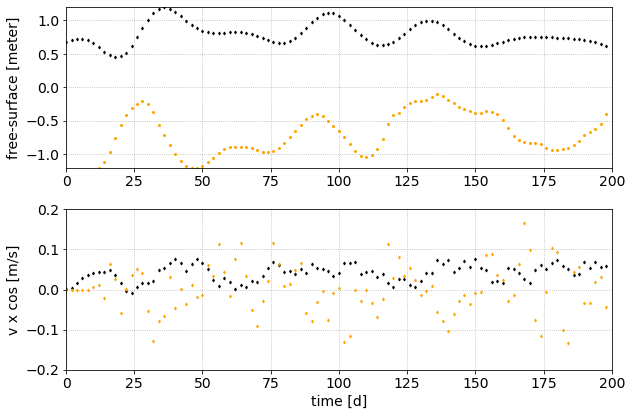

In [11]:
fig=plt.figure(figsize=(9,6))
ax=plt.subplot(211)
ds_ssh['ssh_lof'][:,180,128].plot(color='k', marker='d', ls='', ms=2)
ds_ssh['ssh_lof'][:,480,128].plot(color='orange', marker='o', ls='', ms=2)
ax.set_title('')
plt.xlim(0,200)
plt.ylim(-1.2, 1.2)
plt.xlabel('')
plt.grid(b=True , ls=':')

ax=plt.subplot(212)
ds_v['v_xy_cos'][:,180,128].plot(color='k', marker='d', ls='', ms=2)
ds_v['v_xy_cos'][:,480,128].plot(color='orange', marker='d', ls='', ms=2)
ax.set_title('')
plt.ylim(-0.2,0.2)
plt.xlim(0,200)
plt.xlabel('time [d]')
plt.grid(b=True , ls=':')

plt.tight_layout()

In [12]:
from statsmodels.tsa import stattools


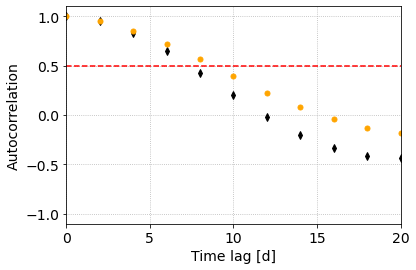

In [13]:
plt.figure()
plt.plot(np.arange(0,11*dt,dt), stattools.acf(ds_ssh['ssh_lof'][:,180,128].values, nlags=10),
        color='k', marker='d', ls='', ms=5)
plt.plot(np.arange(0,11*dt,dt), stattools.acf(ds_ssh['ssh_lof'][:,480,128].values, nlags=10),
        color='orange', marker='o', ls='', ms=5)
# plt.plot(stattools.acf(ds['ssh_cos'][:,360,128].values, nlags=20))
# plt.plot(stattools.acf(ds['ssh_sin'][:,360,128].values, nlags=20))

plt.axhline(0.5,c='r', ls='--')
plt.ylim(-1.1,1.1)
plt.xlim(0, 20)
plt.ylabel('Autocorrelation')
plt.xlabel('Time lag [d]')
plt.grid(b=True, ls=':')

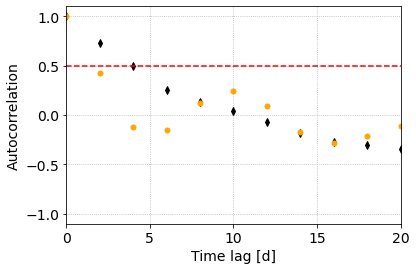

In [14]:
plt.figure()
plt.plot(np.arange(0,11*dt,dt), stattools.acf(ds_v['v_xy_cos'][:,180,128].values, nlags=10),
        color='k', marker='d', ls='', ms=5)
plt.plot(np.arange(0,11*dt,dt), stattools.acf(ds_v['v_xy_cos'][:,480,128].values, nlags=10),
        color='orange', marker='o', ls='', ms=5)
# plt.plot(stattools.acf(ds['ssh_cos'][:,360,128].values, nlags=20))
# plt.plot(stattools.acf(ds['ssh_sin'][:,360,128].values, nlags=20))

plt.axhline(0.5,c='r', ls='--')
plt.ylim(-1.1,1.1)
plt.xlim(0, 20)
plt.ylabel('Autocorrelation')
plt.xlabel('Time lag [d]')
plt.grid(b=True, ls=':')

(0.0, 200.0)

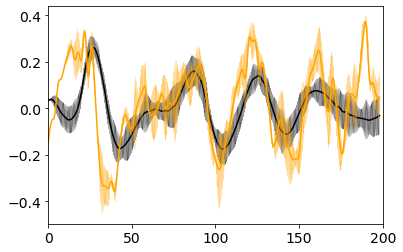

In [17]:
# Reconstruct a time series at a point


def calc_raw_v(xpt, ypt, dtout):
    omega = 2*np.pi*2. # cpd

    tfast = np.arange(0, ds_v.time.values[-1], dtout)

    F = interp1d(ds_v.time.values, ds_v.v_xy_lof[:,ypt, xpt], kind=2)
    vlow = F(tfast)
    F = interp1d(ds_v.time.values, ds_v.v_xy_cos[:,ypt, xpt], kind=2)
    vcos = F(tfast)
    F = interp1d(ds_v.time.values, ds_v.v_xy_sin[:,ypt, xpt], kind=2)
    vsin = F(tfast)

    vraw = vlow + vcos*np.cos(omega*tfast) + vsin*np.sin(omega*tfast)
    
    return tfast, vraw, vlow

dt_days = 1/24
plt.figure()
tfast, vraw, vlow = calc_raw_v(128, 180, dt_days)
tfast, vraw2, vlow2 = calc_raw_v(128, 480, dt_days)

plt.plot(tfast, vraw, c='k', lw=0.2)
plt.plot(tfast, vlow, c='k')

plt.plot(tfast, vraw2, c='orange', lw=0.2)
plt.plot(tfast, vlow2, c='orange')
# plt.xlim(10,12)
plt.xlim(0,200)

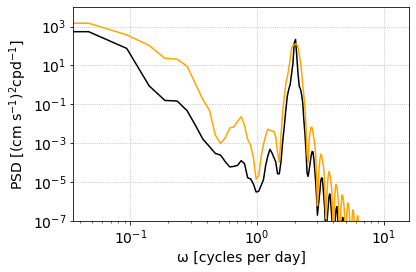

In [20]:
nperseg = 512
y = vraw * 100.
f, Puu= signal.welch(y-y.mean(), fs=1/dt_days, nperseg=nperseg)

y = vraw2 * 100.
f, Puu2 = signal.welch(y-y.mean(), fs=1/dt_days, nperseg=nperseg)

plt.figure()
ax=plt.subplot(111)
plt.loglog(f, Puu, c='k')
plt.loglog(f, Puu2, c='orange')

plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [(cm s$^{-1}$)$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
ax.set_ylim(1e-7, 1e4)
# ax.axvline(f_cpd, c='k', ls=':')
# ax.text(f_cpd+0.1, 1e-1, '$f$')
# plt.title('Latitude: {:3.2f}$^\circ$, Depth (sensor): {:3.1f} m'.format(lat, depth,))
plt.tight_layout()


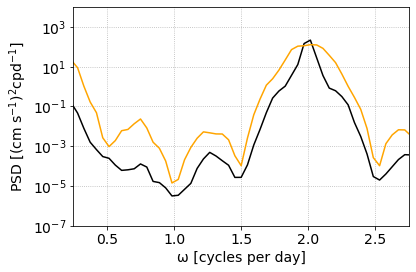

In [21]:
plt.figure()
ax=plt.subplot(111)
plt.semilogy(f, Puu, c='k')
plt.semilogy(f, Puu2, c='orange')

plt.xlabel('ω [cycles per day]')
plt.ylabel('PSD [(cm s$^{-1}$)$^2$cpd$^{-1}$]')
plt.grid(b=True,ls=':')
ax.set_ylim(1e-7, 1e4)
ax.set_xlim(0.25, 2.75)
plt.tight_layout()